In [180]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm, tmin, tmax, tmean, tvar, skew, kurtosis
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import yfinance as yf
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import copy

#### Data Scraping For Index And Index Constituents

In [181]:
class Stock:
    def __init__(self, stock_ticker):
        self.ticker = stock_ticker
        self.meta_data = yf.Ticker(stock_ticker)
        self.series_data = yf.download(stock_ticker, start='2020-01-01', end='2024-12-31', auto_adjust=True)
        self.mean_log_return = 0
        self.variance_log_return = 0
        self.min_log_return = 0
        self.max_log_return = 0
        self.skewness_log_return = 0
        self.kurtosis_log_return = 0
        

class Index(Stock):
    def __init__(self, stock_ticker):
        super().__init__(stock_ticker)
        self.constituents = []
        self.scrap_data()
        
    def scrap_data(self):
        url = 'https://companiesmarketcap.com/south-africa/largest-companies-in-south-africa-by-market-cap/'
        headers = {
            "User-Agent": "Mozilla/5.0"
        }
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.text, 'lxml')
        table = soup.select_one('table.default-table.table.marketcap-table.dataTable')
        tbody = table.find('tbody')
        for tr in tbody.find_all('td', class_='name-td'):
            ticker = tr.find('div', class_='company-code').text
            constituent = Stock(ticker)
            constituent.meta_data = yf.Ticker(constituent.ticker)
            constituent.series_data = yf.download(constituent.ticker, start='2020-01-01', end='2024-12-31', auto_adjust=True)
            self.constituents.append(constituent)
            if len(self.constituents) == 40:
                break

        return 0

In [182]:
FTSE_JSE = Index('^J141.JO')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

#### Analysis

In [183]:
class Analysis:
    def __init__(self):
        pass

    def open_close_plot(self, stock):
        stock_data = {}
        stock_data['Open'] = stock.series_data['Open']
        stock_data['Close'] = stock.series_data['Close']
        
        plt.figure(figsize=(12, 6))
        for price, series in stock_data.items():
            plt.plot(series.index, series.values, label=price)
        
        plt.title(f"{stock.ticker} Open and Close Price")
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def add_log_return(self, stock):
        price_column = 'Close' if 'Close' in stock.series_data.columns else 'Close'
        stock.series_data['Log_Return'] = np.log(stock.series_data[price_column] / stock.series_data[price_column].shift(1))
        log_returns = stock.series_data['Log_Return'].dropna()
        stock.min_log_return = tmin(log_returns)
        stock.max_log_return = tmax(log_returns)
        stock.mean_log_return = tmean(log_returns)
        stock.variance_log_return = tvar(log_returns)
        stock.skewness_log_return = skew(log_returns)
        stock.kurtosis_log_return = kurtosis(log_returns)

    def log_return_distribution(self, stock):
        plt.figure(figsize=(10, 6))
        sns.histplot(stock.series_data['Log_Return'], kde=True, color='mediumseagreen')
        plt.title(f'{stock.ticker} Log Return Distribution with KDE')
        plt.xlabel('Log Returns')
        plt.ylabel('Density')
        plt.grid(True, alpha=0.5)
        plt.show()
        
        plt.figure(figsize=(10, 6))
        sns.ecdfplot(stock.series_data['Log_Return'], color='darkviolet')
        plt.title(f'{stock.ticker} Empirical CDF of Log Returns')
        plt.xlabel('Log Returns')
        plt.ylabel('Cumulative Probability')
        plt.grid(True, alpha=0.5)
        plt.show()

In [184]:
AAnalysis = Analysis()
AAnalysis.add_log_return(FTSE_JSE)
FTSE_JSE.series_data

Price,Close,High,Low,Open,Volume,Log_Return
Ticker,^J141.JO,^J141.JO,^J141.JO,^J141.JO,^J141.JO,
Date,,,,,,
2020-01-02,3225.500000,3253.229980,3211.280029,3211.280029,0,NaN
2020-01-03,3275.620117,3282.429932,3225.500000,3225.500000,0,0.015419
2020-01-06,3258.820068,3303.820068,3252.409912,3275.620117,0,-0.005142
2020-01-07,3238.030029,3258.820068,3197.810059,3258.820068,0,-0.006400
2020-01-08,3250.280029,3277.540039,3238.030029,3238.030029,0,0.003776
...,...,...,...,...,...,...
2024-12-20,3539.429932,3542.280029,3475.909912,3521.270020,0,0.005144
2024-12-23,3523.389893,3562.000000,3502.370117,3539.429932,0,-0.004542


#### Descriptive Statistics of the Log Returns of FTSE/JSE

Minimum of Log Returns: -0.14292373802481068
Maximum of Log Returns: 0.08770011016856373
Mean of Log Returns: 7.52855833932048e-05
Variance of Log Returns: 0.00030139346441890183
Skewness of Log Returns: -0.4985638920228399
Kurtosis of Log Returns: 7.227765090353978


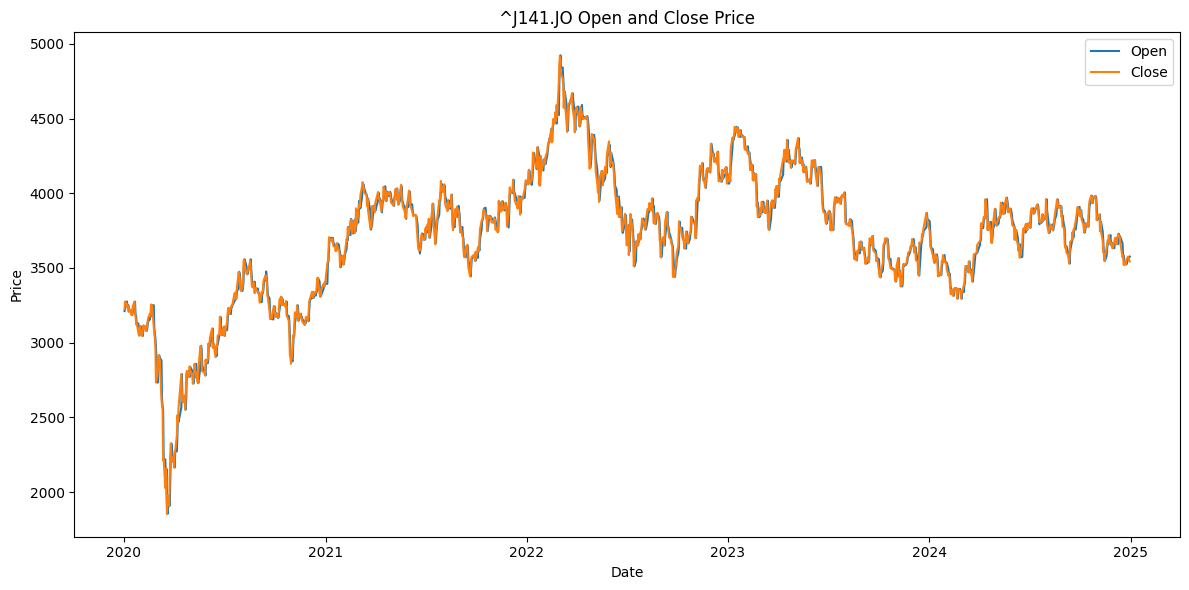

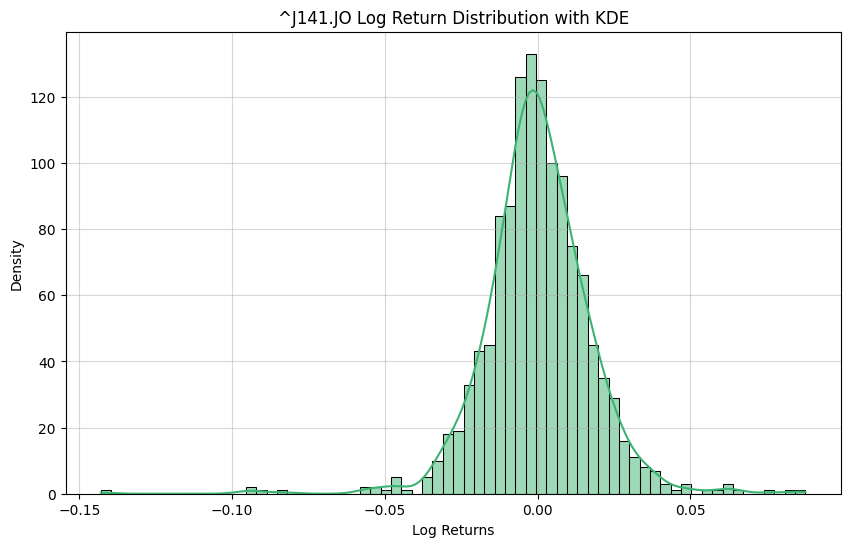

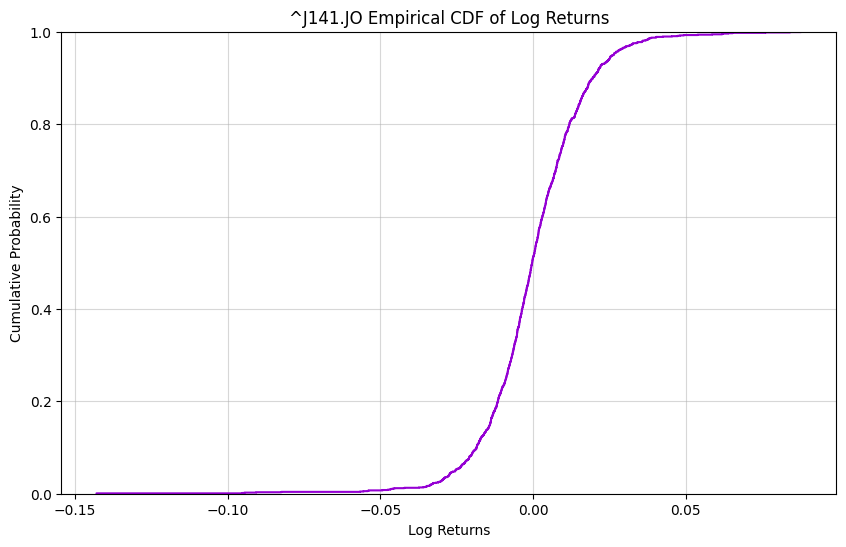

In [185]:
print(f"Minimum of Log Returns: {FTSE_JSE.min_log_return}")
print(f"Maximum of Log Returns: {FTSE_JSE.max_log_return}")
print(f"Mean of Log Returns: {FTSE_JSE.mean_log_return}")
print(f"Variance of Log Returns: {FTSE_JSE.variance_log_return}")
print(f"Skewness of Log Returns: {FTSE_JSE.skewness_log_return}")
print(f"Kurtosis of Log Returns: {FTSE_JSE.kurtosis_log_return}")

AAnalysis.open_close_plot(FTSE_JSE)
AAnalysis.log_return_distribution(FTSE_JSE)

#### Baum-Welch (Expectation-Maximization) Algorithm For Gaussian Hidden Markov Models

In [186]:
class State:
    def __init__(self, Dataset):
        self.initial_probability = np.random.rand()
        self.forward_probabilities = np.zeros(len(Dataset))
        self.backward_probabilities = np.zeros(len(Dataset))
        self.mean = np.random.rand()
        self.variance = np.random.rand()
        self.state_occupations = np.zeros(len(Dataset))

class Hidden_Markov_Model:
    def __init__(self, Dataset, number_of_states):
        self.number_of_states = number_of_states
        self.Dataset = Dataset
        self.States = np.array([State(Dataset) for i in range(number_of_states)])
        self.transition_matrix = np.random.rand(number_of_states, number_of_states)
        self.transition_matrix = self.transition_matrix / np.sum(self.transition_matrix, axis=1, keepdims=True)
        initial_probabilities = np.array([state.initial_probability for state in self.States])
        for state in self.States:
            state.initial_probability /= np.sum(initial_probabilities)

        self.state_transitions = np.zeros((len(Dataset)-1, number_of_states, number_of_states))
        self.forward_scales = np.zeros(len(Dataset))
        self.log_likelihood = 0

    def normalizing(self, array, t):
        normalizing_factor = 0
        for i in range(self.number_of_states):
            normalizing_factor += getattr(self.States[i], array)[t]
        if normalizing_factor > 0:
            for i in range(self.number_of_states):
                getattr(self.States[i], array)[t] = getattr(self.States[i], array)[t] / normalizing_factor
            if array == 'forward_probabilities':
                self.forward_scales[t] = 1 / normalizing_factor
        else:
            self.forward_scales[t] = 0
            for i in range(self.number_of_states):
                getattr(self.States[i], array)[t] = 0


    def forward_algorithm(self, t):
        for i in range(self.number_of_states):
            forward_sum = 0
            for j in range(self.number_of_states):
                forward_sum += self.States[j].forward_probabilities[t-1] * self.transition_matrix[j][i]
            self.States[i].forward_probabilities[t] = forward_sum * norm.pdf(self.Dataset[t], loc=self.States[i].mean, scale=np.sqrt(self.States[i].variance))
        self.normalizing('forward_probabilities', t)

    def backward_algorithm(self, t):
        for i in range(self.number_of_states):
            backward_sum = 0
            for j in range(self.number_of_states):
                backward_sum += self.transition_matrix[i][j] * norm.pdf(self.Dataset[t+1], loc=self.States[j].mean, scale=np.sqrt(self.States[j].variance)) * self.States[j].backward_probabilities[t+1]
            self.States[i].backward_probabilities[t] = backward_sum
        self.normalizing('backward_probabilities', t)

    def state_occupation(self, t):
        denominator = 0
        for j in range(self.number_of_states):
            denominator += self.States[j].forward_probabilities[t] * self.States[j].backward_probabilities[t]
        if denominator > 0:
            for i in range(self.number_of_states):
                self.States[i].state_occupations[t] = self.States[i].forward_probabilities[t] * self.States[i].backward_probabilities[t] / denominator
        else:
            for i in range(self.number_of_states):
                self.States[i].state_occupations[t] = 0

    def state_transition(self, t):
        denominator = 0
        for k in range(self.number_of_states):
            for l in range(self.number_of_states):
                denominator += self.States[k].forward_probabilities[t] * self.transition_matrix[k][l] * norm.pdf(self.Dataset[t+1], loc=self.States[l].mean, scale=np.sqrt(self.States[l].variance)) * self.States[l].backward_probabilities[t+1]
        if denominator > 0:
            for i in range(self.number_of_states):
                for j in range(self.number_of_states):
                    self.state_transitions[t][i][j] = self.States[i].forward_probabilities[t] * self.transition_matrix[i][j] * norm.pdf(self.Dataset[t+1], loc=self.States[j].mean, scale=np.sqrt(self.States[j].variance)) * self.States[j].backward_probabilities[t+1] / denominator
        else:
            for i in range(self.number_of_states):
                for j in range(self.number_of_states):
                    self.state_transitions[t][i][j] = 0

    def e_step(self):
        for i in range(self.number_of_states):
            self.States[i].forward_probabilities[0] = self.States[i].initial_probability * norm.pdf(self.Dataset[0], loc=self.States[i].mean, scale=np.sqrt(self.States[i].variance))
            self.States[i].backward_probabilities[len(self.Dataset)-1] = 1
        self.normalizing('forward_probabilities', 0)

        for t in range(1, len(self.Dataset)):
            self.forward_algorithm(t)
        for t in range(len(self.Dataset)-2, -1, -1):
            self.backward_algorithm(t)
        for t in range(len(self.Dataset)):
            self.state_occupation(t)
        for t in range(len(self.Dataset)-1):
            self.state_transition(t)

    def m_step(self):
        for i in range(self.number_of_states):
            self.States[i].initial_probability = self.States[i].state_occupations[0]

        for i in range(self.number_of_states):
            denominator = np.sum(self.States[i].state_occupations[:-1])
            if denominator > 0:
                for j in range(self.number_of_states):
                    self.transition_matrix[i][j] = np.sum(self.state_transitions[:, i, j]) / denominator
            else:
                self.transition_matrix[i][:] = 1 / self.number_of_states

        for i in range(self.number_of_states):
            denominator = np.sum(self.States[i].state_occupations)
            if denominator > 0:
                self.States[i].mean = np.sum(self.States[i].state_occupations * self.Dataset) / denominator
            else:
                self.States[i].mean = np.random.rand()

        for i in range(self.number_of_states):
            denominator = np.sum(self.States[i].state_occupations)
            if denominator > 0:
                self.States[i].variance = np.sum(self.States[i].state_occupations * (self.Dataset - self.States[i].mean) ** 2) / denominator
                if self.States[i].variance <= 0:
                    self.States[i].variance = np.random.rand()
            else:
                self.States[i].variance = np.random.rand()

    def baum_welch_algorithm(self, threshold, max_iterations=100):
        self.e_step()
        self.m_step()
        new_log_likelihood = -np.sum(np.log(self.forward_scales + 1e-100))
        difference = float('inf')
        iteration = 0

        while difference > threshold and iteration < max_iterations:
            iteration += 1
            previous_log_likelihood = new_log_likelihood
            self.e_step()
            self.m_step()
            new_log_likelihood = -np.sum(np.log(self.forward_scales + 1e-100))
            difference = np.abs(new_log_likelihood - previous_log_likelihood)
            print(f'Iteration {iteration} . . . Log-Likelihood = {new_log_likelihood}')

        self.log_likelihood = new_log_likelihood

In [187]:
FTSE_JSE.series_data

Price,Close,High,Low,Open,Volume,Log_Return
Ticker,^J141.JO,^J141.JO,^J141.JO,^J141.JO,^J141.JO,
Date,,,,,,
2020-01-02,3225.500000,3253.229980,3211.280029,3211.280029,0,NaN
2020-01-03,3275.620117,3282.429932,3225.500000,3225.500000,0,0.015419
2020-01-06,3258.820068,3303.820068,3252.409912,3275.620117,0,-0.005142
2020-01-07,3238.030029,3258.820068,3197.810059,3258.820068,0,-0.006400
2020-01-08,3250.280029,3277.540039,3238.030029,3238.030029,0,0.003776
...,...,...,...,...,...,...
2024-12-20,3539.429932,3542.280029,3475.909912,3521.270020,0,0.005144
2024-12-23,3523.389893,3562.000000,3502.370117,3539.429932,0,-0.004542


In [188]:
Dataset = FTSE_JSE.series_data['Log_Return'].dropna().to_numpy()

In [195]:
model = Hidden_Markov_Model(Dataset, 3)

In [196]:
for i in range(model.number_of_states):
    print(f'==================================== {i} =====================================')
    print(f'Initial Probability: {model.States[i].initial_probability}')
    print(f'Mean: {model.States[i].mean}')
    print(f'Variance: {model.States[i].variance}')
    print('\n')
print(f'Transition Matrix: {model.transition_matrix}')
print(f'Log Likelihood: {model.log_likelihood}')

==================================== 0 =====================================
Initial Probability: 0.17760863635834734
Mean: 0.2818017211988467
Variance: 0.07463001419491111


==================================== 1 =====================================
Initial Probability: 0.0690193258402691
Mean: 0.344929461419745
Variance: 0.4795653034813273


==================================== 2 =====================================
Initial Probability: 0.7533720378013836
Mean: 0.4374132745435191
Variance: 0.5729694024209608


Transition Matrix: [[0.57087279 0.40327253 0.02585468]
 [0.62041012 0.18583175 0.19375813]
 [0.32960131 0.38245483 0.28794386]]
Log Likelihood: 0


In [197]:
model.baum_welch_algorithm(0.001)

Iteration 1 . . . Log-Likelihood = 3289.2566461508513
Iteration 2 . . . Log-Likelihood = 3301.271912381573
Iteration 3 . . . Log-Likelihood = 3352.344185840513
Iteration 4 . . . Log-Likelihood = 3406.0307193687527
Iteration 5 . . . Log-Likelihood = 3417.4378687233284
Iteration 6 . . . Log-Likelihood = 3422.1918901095455
Iteration 7 . . . Log-Likelihood = 3425.866588316928
Iteration 8 . . . Log-Likelihood = 3428.9710031914274
Iteration 9 . . . Log-Likelihood = 3431.598704648989
Iteration 10 . . . Log-Likelihood = 3433.744726168574
Iteration 11 . . . Log-Likelihood = 3435.498914327815
Iteration 12 . . . Log-Likelihood = 3437.001699012123
Iteration 13 . . . Log-Likelihood = 3438.289619473988
Iteration 14 . . . Log-Likelihood = 3439.256759172081
Iteration 15 . . . Log-Likelihood = 3439.818863147082
Iteration 16 . . . Log-Likelihood = 3440.0807843184575
Iteration 17 . . . Log-Likelihood = 3440.2087177812155
Iteration 18 . . . Log-Likelihood = 3440.29141216474
Iteration 19 . . . Log-Likeliho

In [198]:
for i in range(model.number_of_states):
    print(f'==================================== {i} =====================================')
    print(f'Initial Probability: {model.States[i].initial_probability}')
    print(f'Mean: {model.States[i].mean}')
    print(f'Variance: {model.States[i].variance}')
    print('\n')
print(f'Transition Matrix: {model.transition_matrix}')
print(f'Log Likelihood: {model.log_likelihood}')

==================================== 0 =====================================
Initial Probability: 0.9999998641835824
Mean: 9.49467155286728e-05
Variance: 0.00013560935138149041


==================================== 1 =====================================
Initial Probability: 1.3581641762225892e-07
Mean: 0.00032765272128184095
Variance: 0.00038949892304790314


==================================== 2 =====================================
Initial Probability: 9.653309599390855e-168
Mean: -0.002729514741493356
Variance: 0.0027412296581381854


Transition Matrix: [[8.99353193e-01 1.00646218e-01 5.89020625e-07]
 [2.08830860e-01 7.88290030e-01 2.87910942e-03]
 [2.35412185e-08 2.75313664e-02 9.72468610e-01]]
Log Likelihood: 3448.9667784231515


In [199]:
import numpy as np
from hmmlearn import hmm

class HMM_Model:
    def __init__(self, n_components, n_features):
        self.model = hmm.GaussianHMM(n_components=n_components, covariance_type="full", n_iter=100, verbose=True)

    def fit(self, X):
        self.model.fit(X)

    def predict(self, X):
        return self.model.predict(X)

    def get_parameters(self, X):
        print(f'likelihood = {self.model.score(X)}')
        print(f'initial_probabilities = {self.model.startprob_}')
        print(f'means = {self.model.means_}')
        print(f'covariances = {self.model.covars_}')
        print(f'transition_matrix = {self.model.transmat_}')

In [202]:
hmm_model = HMM_Model(n_components=3, n_features=1)
hmm_model.fit(Dataset.reshape(-1, 1))

hmm_model.get_parameters(Dataset.reshape(-1, 1))

         1    2810.25091340             +nan
         2    3332.13961355    +521.88870015
         3    3388.69888247     +56.55926893
         4    3411.91481871     +23.21593623
         5    3424.01467107     +12.09985237
         6    3430.61020219      +6.59553111
         7    3434.16717457      +3.55697238
         8    3435.93433203      +1.76715747
         9    3436.71731388      +0.78298184
        10    3436.99510626      +0.27779239
        11    3437.09312425      +0.09801799
        12    3437.15311243      +0.05998818
        13    3437.21438692      +0.06127449
        14    3437.28186075      +0.06747384
        15    3437.35292529      +0.07106454
        16    3437.42481097      +0.07188568
        17    3437.49579872      +0.07098776
        18    3437.56501117      +0.06921244
        19    3437.63206383      +0.06705266
        20    3437.69682229      +0.06475846
        21    3437.75926414      +0.06244185
        22    3437.81940834      +0.06014420
        23

likelihood = 3438.6651165680473
initial_probabilities = [1.36038938e-01 8.66240976e-72 8.63961062e-01]
means = [[ 0.00144289]
 [-0.00265849]
 [ 0.00010523]]
covariances = [[[0.00089628]]

 [[0.00279275]]

 [[0.00019454]]]
transition_matrix = [[6.15137688e-02 2.24878139e-02 9.15998417e-01]
 [1.24576366e-02 9.65518167e-01 2.20241966e-02]
 [5.30868994e-02 7.91834591e-05 9.46833917e-01]]


        38    3438.48294743      +0.02622840
        39    3438.50758448      +0.02463705
        40    3438.53073486      +0.02315038
        41    3438.55247598      +0.02174112
        42    3438.57283874      +0.02036276
        43    3438.59178907      +0.01895033
        44    3438.60921518      +0.01742611
        45    3438.62492596      +0.01571078
        46    3438.63866411      +0.01373815
        47    3438.65013390      +0.01146978
        48    3438.65903825      +0.00890435


In [201]:
for i in range(model.number_of_states):
    print(f'==================================== {i} =====================================')
    print(f'Initial Probability: {model.States[i].initial_probability}')
    print(f'Mean: {model.States[i].mean}')
    print(f'Variance: {model.States[i].variance}')
    print('\n')
print(f'Transition Matrix: {model.transition_matrix}')
print(f'Log Likelihood: {model.log_likelihood}')

==================================== 0 =====================================
Initial Probability: 0.9999998641835824
Mean: 9.49467155286728e-05
Variance: 0.00013560935138149041


==================================== 1 =====================================
Initial Probability: 1.3581641762225892e-07
Mean: 0.00032765272128184095
Variance: 0.00038949892304790314


==================================== 2 =====================================
Initial Probability: 9.653309599390855e-168
Mean: -0.002729514741493356
Variance: 0.0027412296581381854


Transition Matrix: [[8.99353193e-01 1.00646218e-01 5.89020625e-07]
 [2.08830860e-01 7.88290030e-01 2.87910942e-03]
 [2.35412185e-08 2.75313664e-02 9.72468610e-01]]
Log Likelihood: 3448.9667784231515
